In [1]:
!pip install --upgrade torch torchviz torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.1+cu101)
     |████████████████████████████████| 51kB 2.2MB/s 
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.1+cu101)
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=3a49e685bc270aa70fcb849828453791888386f7351a69b42e35c460822dfd7a
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torch.utils.data as data

In [3]:
print(torch.cuda.is_available())
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [4]:
batch_size = 100
num_classes = 10
epochs = 20

import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 1, 28, 28).astype('float32')
x_test = x_test.reshape(10000, 1, 28, 28).astype('float32')

x_train /= 255
x_test /= 255

y_train = y_train.astype('long')
y_test = y_test.astype('long')
print(x_train.shape)
print(y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 1, 28, 28)
(60000,)


In [5]:
ds_train = data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
ds_test = data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

dataloader_train = data.DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True)
dataloader_test = data.DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=False)

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)

    self.fc1 = nn.Linear(64*14*14, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = f.relu(self.conv1(x))
    x = f.relu(self.conv2(x))
    x = f.max_pool2d(x, (2, 2))
    
    x = x.view(-1, 64*14*14)
    
    x = f.relu(self.fc1(x))
    x = self.dropout2(x)
    return f.relu(self.fc2(x))

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [8]:
global_step = 0

def train(epoch, writer):
  model.train()
  steps = len(ds_train)//batch_size
  for step, (images, labels) in enumerate(dataloader_train, 1):
    global global_step
    global_step += 1
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch, epochs, step, steps, loss.item()))
            writer.add_scalar('train/train_loss', loss.item() , global_step)
            loss_history.append(loss.item())


In [9]:
global_step1 = 0

def eval(epoch, writer):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for (images, labels) in dataloader_test:
      global global_step1
      global_step1 += 1
      print(images.shape)

      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
      if global_step1 % 100 == 0:
        acc_history.append(correct/total)
        loss_history_test.append(loss)

    print("Val Acc : %.4f" % (correct/total))
    writer.add_scalar('eval/val_acc', correct*100/total, epoch)

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import torch.nn.init as init

def _initialize_weights(self):
  for m in self.modules():
    if isinstance(m, nn.Conv2d):
      init.xavier_uniform_(m.weight.data, gain=init.calculate_gain('relu'))



loss_history = []
loss_history_test = []
acc_history = []
for epoch in range(1, epochs+1):
  train(epoch, writer)
  eval(epoch, writer)

writer.close()

Epoch [1/20], Step [100/600], Loss: 0.9602
Epoch [1/20], Step [200/600], Loss: 0.4212
Epoch [1/20], Step [300/600], Loss: 0.4971
Epoch [1/20], Step [400/600], Loss: 0.3954
Epoch [1/20], Step [500/600], Loss: 0.4810
Epoch [1/20], Step [600/600], Loss: 0.2653
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 

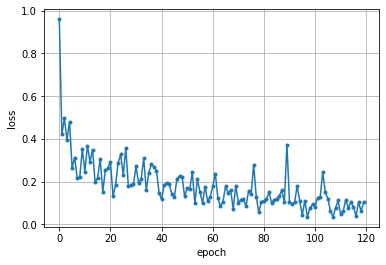

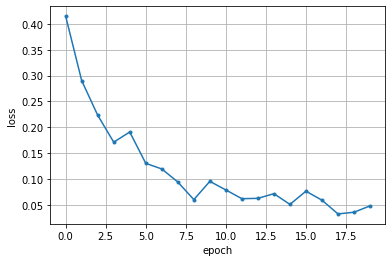

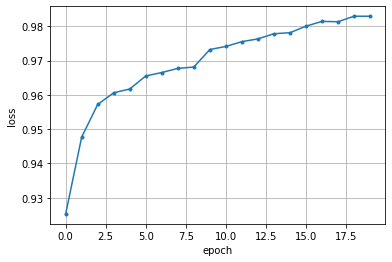

In [11]:
import matplotlib.pyplot as plt

epochs = len(loss_history)
plt.plot(range(epochs), loss_history, marker='.', label='loss train')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epochs = len(loss_history_test)
plt.plot(range(epochs), loss_history_test, marker='.', label='loss test')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epochs = len(acc_history)
plt.plot(range(epochs), acc_history, marker='.', label='loss train')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 204kB 2.7MB/s 
